# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\alexie\appdata\local\temp\pip-req-build-ffqu1hdb
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Alexie\AppData\Local\Temp\pip-req-build-ffqu1hdb'


In [10]:
import numpy as np
import torch
import torchvision.transforms as transforms
from pkg_resources import packaging
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import clip
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
print("Torch version:", torch.__version__)


Torch version: 2.4.1+cpu


# Loading the Model

`clip.available_models()` will list the names of available CLIP models.

In [11]:
# will output the list of names of available Clip Models
clip.available_models()

# Loading the CLIP mdoel and preprocessing it
#why did i use this model????
model, preprocess = clip.load("ViT-B/32", device="cpu" )

# Downloading and Loading the Dataset

In [12]:
# Load the MNIST dataset
# Convert the grayscale image to 3 channels (RGB)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to CLIP's input resolution
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1] as expected by CLIP
])

# Download the MNIST dataset and apply transformations
mnist_train = MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test = MNIST(root="./data", train=False, transform=transform, download=True)

# Use DataLoader to iterate over the dataset
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)

# Helper function for the prompt

In [13]:
# Helper function to parse the text prompt
def parse_text_prompt(prompt):
    """Parses a text prompt like 'add 3' or 'subtract 2' and returns the operation."""
    match = re.match(r'(add|subtract) (\d+)', prompt.lower())
    if not match:
        raise ValueError("Prompt must be in the form of 'add X' or 'subtract X'")
    operation, value = match.groups()
    value = int(value)
    return operation, value

# Function to modify the label based on the text prompt
def modify_label(original_label, prompt):
    operation, value = parse_text_prompt(prompt)
    if operation == 'add':
        return original_label + value
    elif operation == 'subtract':
        return original_label - value
    return original_label

# Prompts

In [14]:
prompt = "add 2"

# Processing the image and passing it through clip 

Original label: 5
New label based on prompt 'add 2': 7


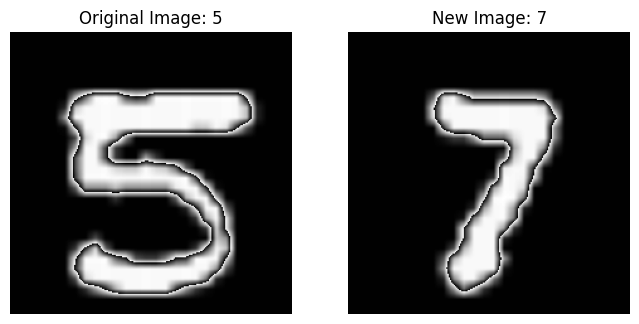

In [15]:
# Get a random sample from MNIST
for images, labels in train_loader:
    images = images.to("cpu")
    
    # Select the first image and its label
    original_image = images[0]
    original_label = labels[0].item()
    

    # Print the original label (for example, it might be 3)
    print(f"Original label: {original_label}")

    # Modify the label based on the prompt
    new_label = modify_label(original_label, prompt)

    # Clip the label between 0 and 9 (since MNIST digits are 0-9)
    new_label = max(0, min(9, new_label))
    print(f"New label based on prompt '{prompt}': {new_label}")

    # Find an image from the MNIST dataset with the new label
    mnist_images_with_new_label = [img for img, label in mnist_train if label == new_label]
    if mnist_images_with_new_label:
        # Randomly select an image of the new label from the dataset
        new_image = random.choice(mnist_images_with_new_label)
        
        # Convert the images back to PIL for displaying
        original_image_pil = transforms.ToPILImage()(original_image)
        new_image_pil = transforms.ToPILImage()(new_image)
        
        # Display the original and new image side by side
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        axs[0].imshow(original_image_pil)
        axs[0].set_title(f"Original Image: {original_label}")
        axs[0].axis('off')

        axs[1].imshow(new_image_pil)
        axs[1].set_title(f"New Image: {new_label}")
        axs[1].axis('off')

        plt.show()

    break  # Just for example purposes; remove to process the whole dataset
